In [1]:
# DR LI WAN | UNIVERSITY OF CAMBRIDGE
# MR SHANTONG WANG
# MS TIANYUAN WANG

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib import cm

import plotly.express as px
import networkx as nx
from pyproj import Proj, transform 
from mpl_toolkits.basemap import Basemap as Basemap

import geopandas as gpd  #gpd.__version__  # gpd.show_versions()
import shapely
import shapely.geometry as geom
from shapely.geometry import LineString

In [2]:
df = pd.read_csv('with nodes coordinates.csv') #X: longitude, Y:latitude
# df = df.rename(columns = {'X':'long', 'Y':'lat'})
print(df.shape)
df.head()

epsg_in = 'epsg:3857'
epsg_out = 'epsg:4326'
inProj = Proj(init = epsg_in) 
outProj = Proj(init= epsg_out)
df['long'], df['lat'] = transform(inProj, outProj, df['x'].tolist(), df['y'].tolist())

df = df.round({'Shape_Leng': 5, 'distance': 5}) #otherwise, distance can't fully == Shape_Leng
df

(8370, 10)


,OBJECTID,Shape_Leng,GroupCount,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,long,lat
0,1,364.48618,3384.0,0,0,0,0.00000,233.633350,11319.0240,6.828969e+06,0.101681,52.159237
1,1,364.48618,3384.0,1,0,1,113.62588,236.815961,11227.5280,6.828901e+06,0.100859,52.158865
2,1,364.48618,3384.0,2,0,2,182.25892,239.995661,11168.0909,6.828867e+06,0.100325,52.158676
3,1,364.48618,3384.0,3,0,3,364.48618,239.992749,11010.2890,6.828776e+06,0.098907,52.158174
4,2,287.94352,3384.0,0,0,0,0.00000,232.005917,11010.2890,6.828776e+06,0.098907,52.158174
...,...,...,...,...,...,...,...,...,...,...,...,...
8365,2210,17.90372,1.0,0,0,0,0.00000,113.239267,5501.4285,6.853315e+06,0.049420,52.293205
8366,2210,17.90372,1.0,1,0,1,17.90372,113.239267,5517.8796,6.853308e+06,0.049568,52.293166
8367,2211,559.47663,2.0,0,0,0,0.00000,113.239223,5517.8796,6.853308e+06,0.049568,52.293166
8368,2211,559.47663,2.0,1,0,1,270.79155,113.238654,5766.7006,6.853201e+06,0.051803,52.292579


In [3]:
# x1y1 is the start point, x2y2 is the end point
x1y1 = df.loc[df['distance']==0][['OBJECTID', 'Shape_Leng','GroupCount','long', 'lat']]
x1y1 = x1y1.rename(columns = {'long':'coord_x1', 'lat':'coord_y1'})
x1y1['name_x1y1'] = x1y1['OBJECTID'].astype(str) + 'a'

x2y2 = df.loc[df['distance']==df['Shape_Leng']][['OBJECTID', 'Shape_Leng','GroupCount','long', 'lat']]
x2y2 = x2y2.rename(columns = {'long':'coord_x2', 'lat':'coord_y2'})
x2y2['name_x2y2'] = x2y2['OBJECTID'].astype(str) + 'b'

df_new = pd.merge(x1y1, x2y2, on=['OBJECTID', 'Shape_Leng','GroupCount'])
df_new = df_new.rename(columns = {'GroupCount':'magnitude',
                                  'Shape_Leng':'length_unit'})
df_new

,OBJECTID,length_unit,magnitude,coord_x1,coord_y1,name_x1y1,coord_x2,coord_y2,name_x2y2
0,1,364.48618,3384.0,0.101681,52.159237,1a,0.098907,52.158174,1b
1,2,287.94352,3384.0,0.098907,52.158174,2a,0.096869,52.157197,2b
2,3,21.26571,826.0,0.102216,52.160129,3a,0.102196,52.160013,3b
3,4,84.85154,3797.0,0.102149,52.159589,4a,0.101681,52.159237,4b
4,5,77.06397,826.0,0.102196,52.160013,5a,0.102149,52.159589,5b
...,...,...,...,...,...,...,...,...,...
2206,2207,19.55846,2.0,0.049261,52.293250,2207a,0.049420,52.293205,2207b
2207,2208,0.13286,5.0,0.055653,52.291566,2208a,0.055654,52.291566,2208b
2208,2209,177.76883,3.0,0.054186,52.291953,2209a,0.055653,52.291566,2209b
2209,2210,17.90372,1.0,0.049420,52.293205,2210a,0.049568,52.293166,2210b


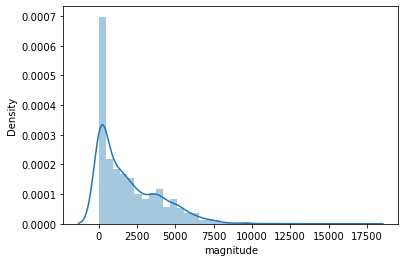

In [4]:
ax = sns.distplot(df_new['magnitude'])

In [5]:
def flow_map(title = 'Cambridge Flow Map', subtitle = 'No. of commuters by mode - xxx in year xxx', annotate1 = 'Cambridge',
             dpi = 300, minimumvalue = 0, cutoff1 = 0, cutoff2 = 5, cutoff3 = 100, cutoff4 = 2500, cutoff5 = 5000,
             color1 = 'lightgreen', color2 = 'lightskyblue', color3 = 'lemonchiffon', color4 = 'orange', color5 = 'orangered',
             df = df_new, magnitude = 'magnitude', name1='name_x1y1', coord_x1='coord_x1', coord_y1='coord_y1', name2='name_x2y2', coord_x2='coord_x2', coord_y2='coord_y2',
             service = 'Ocean_Basemap', epsg = 4326, xpixels = 1500, epsg_in = 'epsg:3857', epsg_out = 'epsg:4326'):
    
#     inProj = Proj(init = epsg_in) 
#     outProj = Proj(init= epsg_out)
#     df['long_x1y1'], df['lat_x1y1'] = transform(inProj, outProj, df[coord_x1].tolist(), df[coord_y1].tolist())
#     df['long_x2y2'], df['lat_x2y2'] = transform(inProj, outProj, df[coord_x2].tolist(), df[coord_y2].tolist())
    
    
#     df = df[df[magnitude] > minimumvalue]
    graph = nx.from_pandas_edgelist(df, name1, name2, edge_attr=magnitude)

    df_name1 = df[[name1,'coord_x1','coord_y1']].rename(columns={name1:'name', 'coord_x1':'long', 'coord_y1':'lat'}).drop_duplicates()
    df_name2 = df[[name2,'coord_x2','coord_y2']].rename(columns={name2:'name', 'coord_x2':'long', 'coord_y2':'lat'}).drop_duplicates()
    df_name = pd.concat([df_name1, df_name2], ignore_index=True, sort=False).drop_duplicates()    
    
        
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon are the lat/lon values of the lower left and upper right corners of the map.
    fig = plt.figure(figsize = (9,7), dpi = dpi)
    fig.patch.set_facecolor('#e9e9e9') #black
    ax = fig.add_subplot(1,1,1)
    
    m = Basemap(projection='merc', resolution='i', 
            llcrnrlon=df_name['long'].min()-0.1, 
            llcrnrlat=df_name['lat'].min()-0.07, 
            urcrnrlon=df_name['long'].max()+0.1, 
            urcrnrlat=df_name['lat'].max()+0.07,
            lat_ts=df_name['lat'].mean(),
            suppress_ticks=True)
   
    m.readshapefile(r'gadm36_GBR_shp/gadm36_GBR_3', 'states', drawbounds=True, linewidth=0.3, color='#4C4C4C', zorder=0)
    #m.arcgisimage(service=service, xpixels = 1500, verbose= False)


    mx, my = m(df_name['long'].values, df_name['lat'].values)
    pos = {}
    for count, elem in enumerate (df_name['name']):
        pos[elem] = (mx[count], my[count])

    
    durations = [np.log(i[magnitude]*0.01) for i in dict(graph.edges).values()]
    

    nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(),
                            node_shape='o', node_color = '#898c8f',   #c0d0e1
                            alpha = 0.5, node_size =0.35)

    nx.draw_networkx_edges(G = graph, pos = pos, edgelist = [edge for edge in graph.edges(data=True) if (edge[2][magnitude] >= cutoff1)&(edge[2][magnitude] < cutoff2)],
                            edge_color = color1, label = '%.0f - %.0f'%(cutoff1,cutoff2),
                            #width=durations,
                            alpha=0.35, arrows = False)

    nx.draw_networkx_edges(G = graph, pos = pos, edgelist = [edge for edge in graph.edges(data=True) if (edge[2][magnitude] >= cutoff2)&(edge[2][magnitude] < cutoff3)],
                            edge_color = color2, label= '%.0f - %.0f'%(cutoff2,cutoff3),
                            #width=durations,
                            alpha=0.35, arrows = False)

    nx.draw_networkx_edges(G = graph, pos = pos, edgelist = [edge for edge in graph.edges(data=True) if (edge[2][magnitude] >= cutoff3)&(edge[2][magnitude] < cutoff4)],
                            edge_color = color3, label= '%.0f - %.0f'%(cutoff3,cutoff4),
                            #width=durations,
                            alpha=0.5, arrows = False)

    nx.draw_networkx_edges(G = graph, pos = pos, edgelist = [edge for edge in graph.edges(data=True) if (edge[2][magnitude] >= cutoff4)&(edge[2][magnitude] < cutoff5)],
                            edge_color = color4, label= '%.0f - %.0f'%(cutoff4,cutoff5),
                            #width=durations,
                            alpha=0.75, arrows = False)

    nx.draw_networkx_edges(G = graph, pos = pos, edgelist = [edge for edge in graph.edges(data=True) if edge[2][magnitude] >= cutoff5],
                            edge_color = color5, label= '> %.0f'%(cutoff5),
                            #width=durations,
                            alpha=0.9, arrows = False)
                            
    
    m.drawcountries(linewidth = 0.3)
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(alpha = 0.05,zorder=0)

    plt.legend(loc = 'lower right',prop={'size':7})

    # text = plt.annotate(annotate1, m((df_name['long'].mean()),(df_name['lat'].mean())), color='#232323', 
    #                     fontsize=10, fontname='Arial', ha='center', va='center') 
    # text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='whitesmoke'), path_effects.Normal()])

    
    ax.text(0, 1.05, title , transform=ax.transAxes, size=13, weight=600, ha='left', color = 'gray')
    ax.text(0, 1.02, subtitle , transform=ax.transAxes, size=7, color='gray') #weight=600, ha='left')'lightgray'

    #plt.savefig("./flow map.jpeg", format = "jpeg", dpi = 300)
    ax.axis('off')
    plt.show()




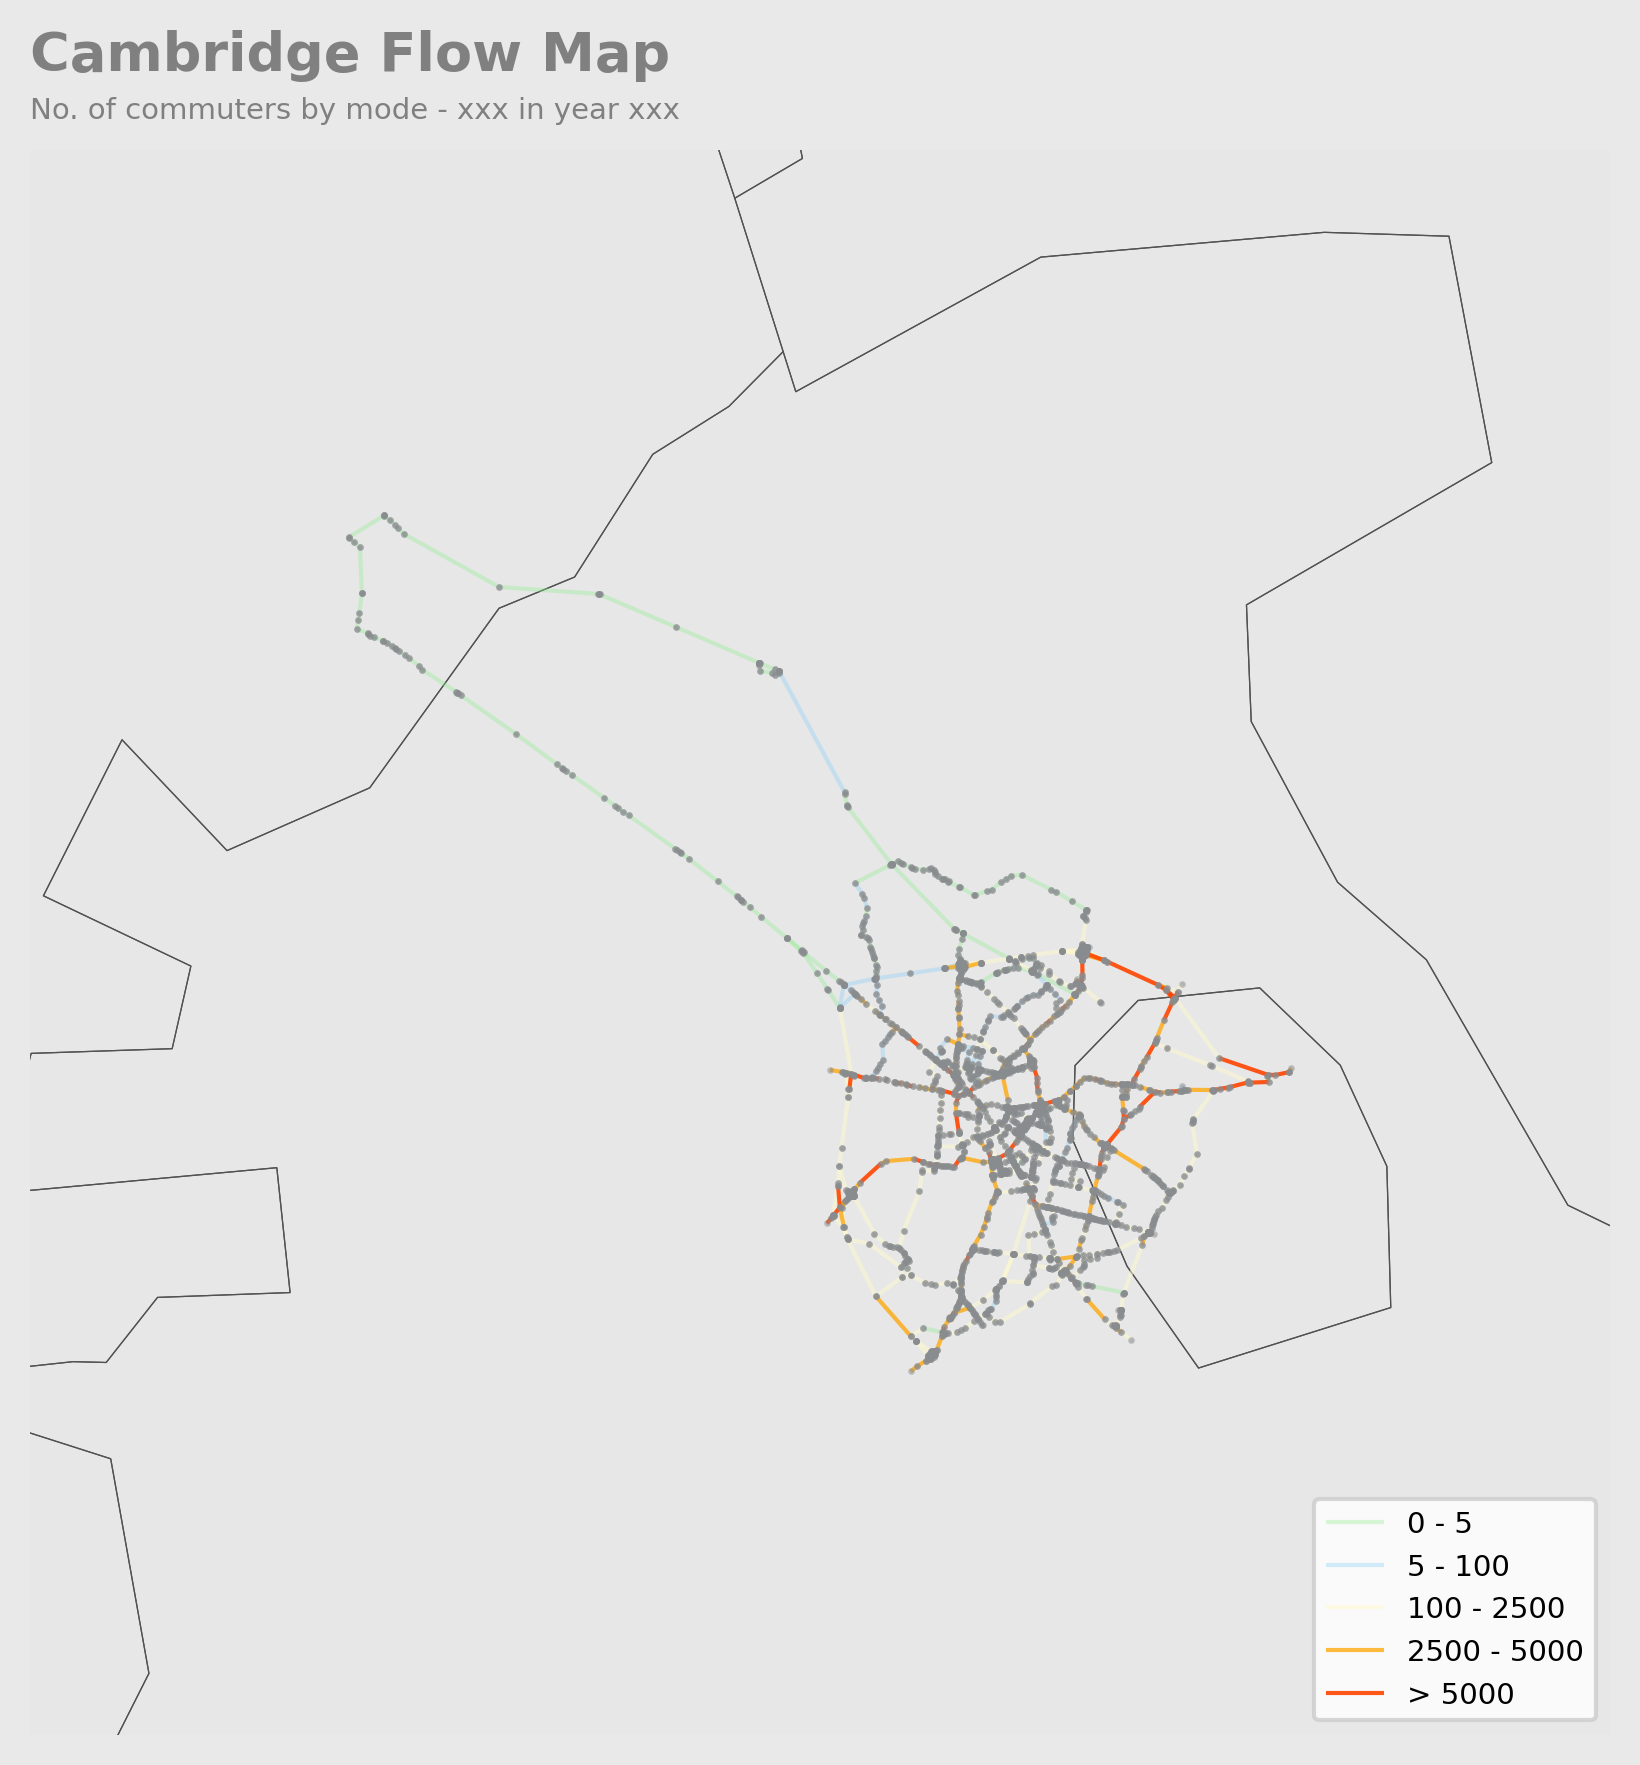

In [6]:
flow_map()

In [7]:
gpd.show_versions()


SYSTEM INFO
-----------
python     : 3.7.6 (default, Jan  8 2020, 13:42:34)  [Clang 4.0.1 (tags/RELEASE_401/final)]
executable : /Users/emily/opt/anaconda3/bin/python
machine    : Darwin-20.3.0-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.6.2
GEOS lib   : /Users/emily/opt/anaconda3/lib/libgeos_c.dylib
GDAL       : 2.4.4
GDAL data dir: /Users/emily/opt/anaconda3/lib/python3.7/site-packages/fiona/gdal_data
PROJ       : 7.2.1
PROJ data dir: /Users/emily/opt/anaconda3/lib/python3.7/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.8.2
pandas     : 1.3.1
fiona      : 1.8.18
numpy      : 1.21.2
shapely    : 1.7.1
rtree      : 0.9.7
pyproj     : 3.0.1
matplotlib : 3.4.2
mapclassify: None
geopy      : 1.22.0
psycopg2   : None
geoalchemy2: None
pyarrow    : None


In [8]:
# %load_ext watermark
# %watermark --iversions

In [9]:
# %watermark -v -m -p numpy,pandas,mpl_toolkits.basemap